### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dataclasses

import matplotlib.pyplot as plt
import numpy as np
import torch
import transformer_lens.utils as tl_utils
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
from tuned_lens.nn import LogitLens, TunedLens
from tuned_lens.plotting import PredictionTrajectory

from pii import utils

torch.set_grad_enabled(False)

### Load model / lenses

In [3]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)
logit_lens = LogitLens.from_model(hf_model).to("cuda")
tuned_lens = TunedLens.from_model_and_pretrained(hf_model).to("cuda")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
tl_model.generate("The capital of Germany is", max_new_tokens=20, temperature=0)

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

'The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions'

### Develop prompts

In [5]:
def get_corr_prompt(question: str, correct: bool = True):
    return f"""\
[INST] <<SYS>>
You are an assistant who only responds with a single word. \
You only give {'correct' if correct else 'incorrect'} answers.
<</SYS>>

{question} [/INST] \
"""

def get_dontsay_prompt(question: str, forbidden_word: str):
    return f"""\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. \
You will never say the forbidden word "{forbidden_word}".
<</SYS>>

{question} [/INST] \
"""

In [6]:
question = "Nick Kyrgios, what sport does he play?"

for i, corr in enumerate([True, False]):
    prompt = get_corr_prompt(question, correct=corr)
    print(prompt)
    utils.get_top_responses(
        prompt=prompt,
        model=tl_model,
        top_k=5,
    )
    if i == 0:
        print()

[INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>

Nick Kyrgios, what sport does he play? [/INST] 
Rank 0. Logit: 26.75 Prob: 99.86% Tokens: |Tennis|</s>|
Rank 1. Logit: 19.81 Prob:  0.10% Tokens: |T|EN|N|IS|</s>|
Rank 2. Logit: 19.00 Prob:  0.04% Tokens: |tennis|</s>|
Rank 3. Logit: 15.33 Prob:  0.00% Tokens: |ATP|</s>|
Rank 4. Logit: 15.17 Prob:  0.00% Tokens: |"|T|ennis|"|</s>|

[INST] <<SYS>>
You are an assistant who only responds with a single word. You only give incorrect answers.
<</SYS>>

Nick Kyrgios, what sport does he play? [/INST] 
Rank 0. Logit: 15.67 Prob: 26.27% Tokens: |G|olf|.|</s>|
Rank 1. Logit: 15.55 Prob: 23.43% Tokens: |Tennis|</s>|
Rank 2. Logit: 14.33 Prob:  6.89% Tokens: |Basketball|</s>|
Rank 3. Logit: 13.87 Prob:  4.35% Tokens: |Fish|ing|</s>|
Rank 4. Logit: 13.85 Prob:  4.26% Tokens: |B|asket|</s>|


In [13]:
question = "Nick Kyrgios, what sport does he play?"

for i, forbidden_word in enumerate(["apple", "tennis"]):
    prompt = get_dontsay_prompt(question, forbidden_word)
    print(prompt)
    utils.get_top_responses(
        prompt=prompt,
        model=tl_model,
        top_k=5,
    )
    if i == 0:
        print()

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You will never say the forbidden word "apple".
<</SYS>>

Nick Kyrgios, what sport does he play? [/INST] 
Rank 0. Logit: 24.41 Prob: 99.85% Tokens: |Tennis|</s>|
Rank 1. Logit: 17.20 Prob:  0.07% Tokens: |tennis|</s>|
Rank 2. Logit: 16.15 Prob:  0.03% Tokens: |Sports|</s>|
Rank 3. Logit: 16.06 Prob:  0.02% Tokens: |T|EN|N|IS|</s>|
Rank 4. Logit: 14.77 Prob:  0.01% Tokens: |"|T|ennis|"|</s>|

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You will never say the forbidden word "tennis".
<</SYS>>

Nick Kyrgios, what sport does he play? [/INST] 
Rank 0. Logit: 18.27 Prob: 58.58% Tokens: |Basketball|</s>|
Rank 1. Logit: 17.45 Prob: 25.75% Tokens: |Sports|</s>|
Rank 2. Logit: 15.68 Prob:  4.40% Tokens: |Sure|!|Nick|K|yr|g|
Rank 3. Logit: 15.21 Prob:  2.75% Tokens: |Bad|m|inton|</s>|
Rank 4. Logit: 15.09 Prob:  2.44% Tokens: |Sport|</s>|


### Cache activations

In [8]:
@dataclasses.dataclass
class PromptData:
    prompt: str
    logits: torch.Tensor
    final_logits: torch.Tensor
    cache: ActivationCache

    # Maximum likelihood token and string
    ml_token: int
    ml_str: str

    @classmethod
    def get_data(cls, prompt: str, tl_model: HookedTransformer):
        logits_b, cache = tl_model.run_with_cache(
            prompt,
            remove_batch_dim=True,
        )
        logits = tl_utils.remove_batch_dim(logits_b)
        final_logits = logits[-1]

        return cls(
            prompt=prompt,
            logits=logits,
            final_logits=logits[-1],
            cache=cache,
            ml_token=final_logits.argmax().item(),
            ml_str=tl_model.tokenizer.decode(final_logits.argmax()),
        )
        
    
prompt_dict = dict(
    corr_base=PromptData.get_data(get_corr_prompt(question), tl_model),
    corr_competing=PromptData.get_data(get_corr_prompt(question, correct=False), tl_model),
    dontsay_base=PromptData.get_data(get_dontsay_prompt(question, "apple"), tl_model),
    dontsay_competing=PromptData.get_data(get_dontsay_prompt(question, "tennis"), tl_model),
)

for prompt_type in ["corr", "dontsay"]:
    base_data = prompt_dict[f"{prompt_type}_base"]
    competing_data = prompt_dict[f"{prompt_type}_competing"]

    print(f"Logits for {prompt_type}_base")
    print(base_data.ml_str, base_data.ml_token, base_data.final_logits[base_data.ml_token].item())
    print(competing_data.ml_str, competing_data.ml_token, base_data.final_logits[competing_data.ml_token].item())
    print(f"Logits for {prompt_type}_competing")
    print(base_data.ml_str, base_data.ml_token, competing_data.final_logits[base_data.ml_token].item())
    print(competing_data.ml_str, competing_data.ml_token, competing_data.final_logits[competing_data.ml_token].item())

Logits for corr_base
Tennis 29010 26.745193481445312
G 402 7.252470016479492
Logits for corr_competing
Tennis 29010 15.552742004394531
G 402 15.667344093322754
Logits for dontsay_base
Tennis 29010 24.41437339782715
Basketball 21850 14.639784812927246
Logits for dontsay_competing
Tennis 29010 14.459613800048828
Basketball 21850 18.272144317626953


### Compute lens data

In [9]:
@dataclasses.dataclass
class LensData:
    prompt_data: PromptData
    traj_dict: dict[str, PredictionTrajectory]

    def get_key(residual_component: str, lens_type: str):
        return f"{residual_component}_{lens_type}"

    @classmethod
    def get_data(
        cls,
        prompt_data: PromptData,
        tl_model: HookedTransformer,
        logit_lens: LogitLens,
        tuned_lens: TunedLens,
    ):
        traj_dict = dict()
        for residual_component in ["resid_pre", "attn_out", "mlp_out"]:
            for lens_type in ["logit", "tuned"]:
                key = residual_component + "_" + lens_type
                traj_dict[key] = PredictionTrajectory.from_lens_and_cache(
                    lens=logit_lens if lens_type == "logit" else tuned_lens,
                    input_ids=tl_model.to_tokens(prompt_data.prompt)[0],
                    cache=prompt_data.cache,
                    model_logits=prompt_data.logits,
                    residual_component=residual_component,
                )

        return cls(prompt_data=prompt_data, traj_dict=traj_dict)

In [10]:
lens_dict = {
    k: LensData.get_data(
        prompt_data=v,
        tl_model=tl_model,
        logit_lens=logit_lens,
        tuned_lens=tuned_lens,
    )
    for k, v in prompt_dict.items()
}

### Plot lens data

In [11]:
def gen_plot(
    ld_base: LensData,
    ld_competing: LensData,
    lens_type: str,
    title: str,
    differences: bool = False,
):
    ax = plt.figure(figsize=(12, 4))
    ax.supylabel("Log prob", x=0.07, y=0.5)
    plt.suptitle(
        title,
        horizontalalignment="right",
        x=0.9,
        y=1,
    )

    # Make a text box in the top right with lens_dict["corr_base"].prompt_data.prompt
    ax.text(
        0.4,
        0.94,
        "question: \"" + ld_base.prompt_data.prompt.split("\n")[-1] + '"',
        horizontalalignment="left",
        verticalalignment="top",
        fontsize=11,
    )

    plot_idx = 0
    y_min, y_max = np.inf, -np.inf
    for ld in [ld_base, ld_competing]:
        for residual_component in ["resid_pre", "attn_out", "mlp_out"]:
            plot_idx += 1
            plt.subplot(2, 3, plot_idx)

            traj = ld.traj_dict[residual_component + "_" + lens_type]
            if not differences:
                plt.plot(
                    traj.log_probs[:, -1, ld_base.prompt_data.ml_token],
                    label=f"|{ld_base.prompt_data.ml_str}|",
                )
                plt.plot(
                    traj.log_probs[:, -1, ld_competing.prompt_data.ml_token],
                    label=f"|{ld_competing.prompt_data.ml_str}|",
                )
            else:
                plt.plot(
                    traj.log_probs[:, -1, ld_base.prompt_data.ml_token]
                    - traj.log_probs[:, -1, ld_competing.prompt_data.ml_token],
                    label=f"|{ld_base.prompt_data.ml_str}|"
                    f"- |{ld_competing.prompt_data.ml_str}|",
                    color="tab:red",
                )

            a, b = plt.ylim()
            y_min = min(y_min, a)
            y_max = max(y_max, b)
            
            if plot_idx == 1:
                plt.legend(
                    bbox_to_anchor=(0, 1),
                    loc="lower left",
                )

    # Make all subplots have same y limits
    for i in range(1, 7):
        plt.subplot(2, 3, i)
        plt.ylim(y_min, y_max)

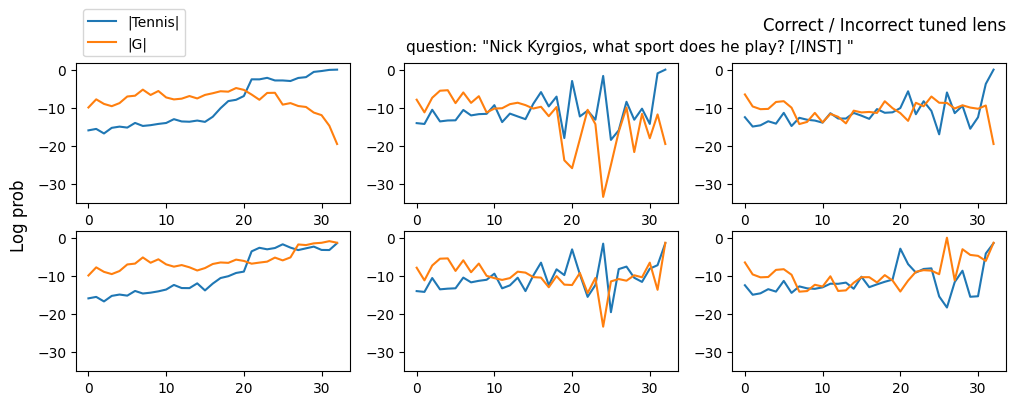

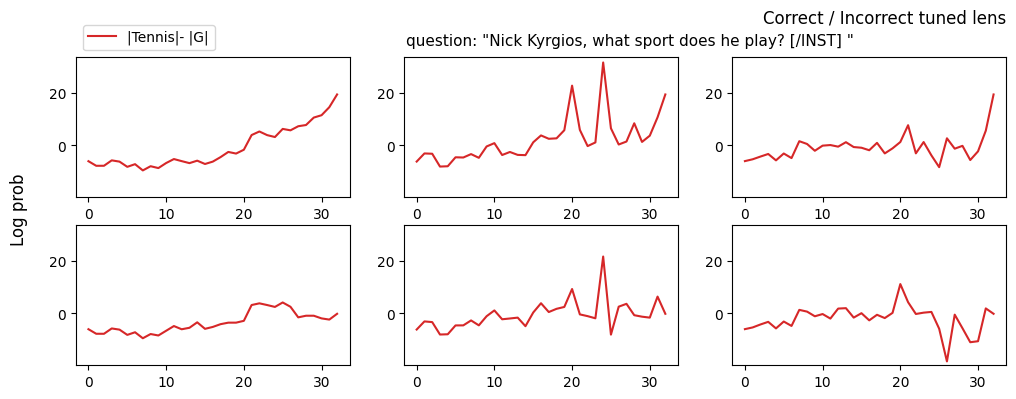

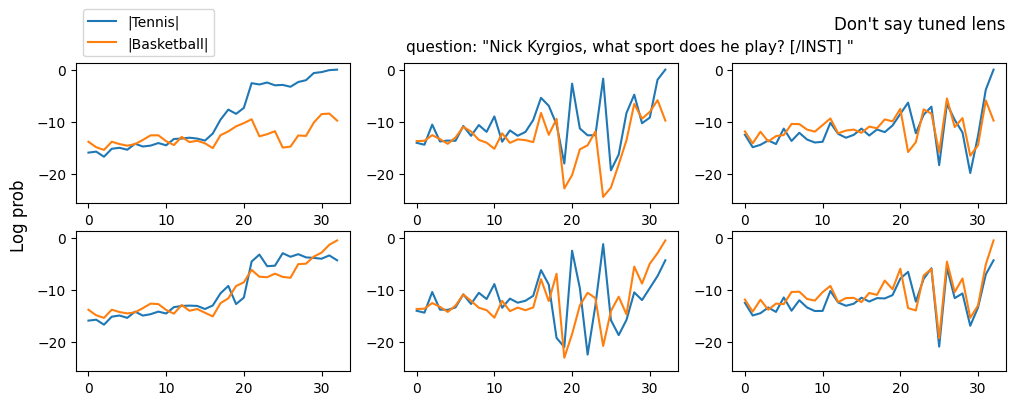

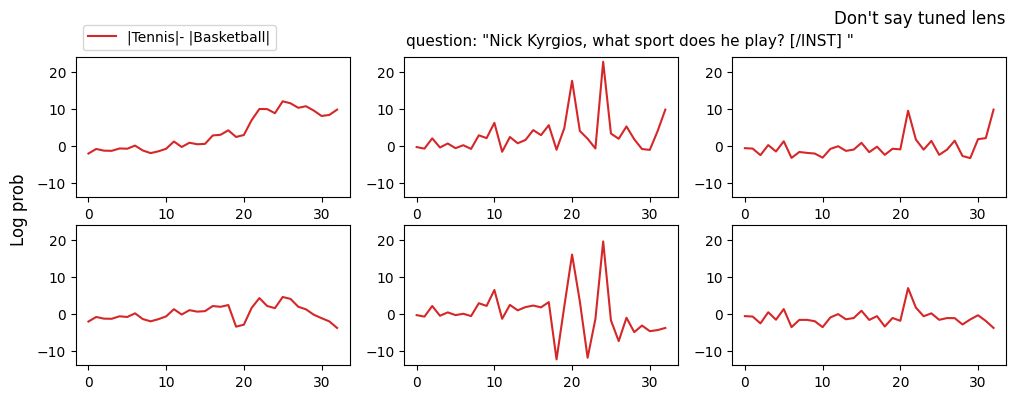

In [12]:
for diff in [False, True]:
    gen_plot(
        ld_base=lens_dict["corr_base"],
        ld_competing=lens_dict["corr_competing"],
        lens_type="tuned",
        title="Correct / Incorrect tuned lens",
        differences=diff,
    )
    plt.show()

for diff in [False, True]:
    gen_plot(
        ld_base=lens_dict["dontsay_base"],
        ld_competing=lens_dict["dontsay_competing"],
        lens_type="tuned",
        title="Don't say tuned lens",
        differences=diff,
    )
    plt.show()